# Mercari Price Suggestion Challenge (Live Kaggle Event)

URL : https://www.kaggle.com/c/mercari-price-suggestion-challenge

Leaderboard: https://www.kaggle.com/c/mercari-price-suggestion-challenge/leaderboard

#### Latest Standing

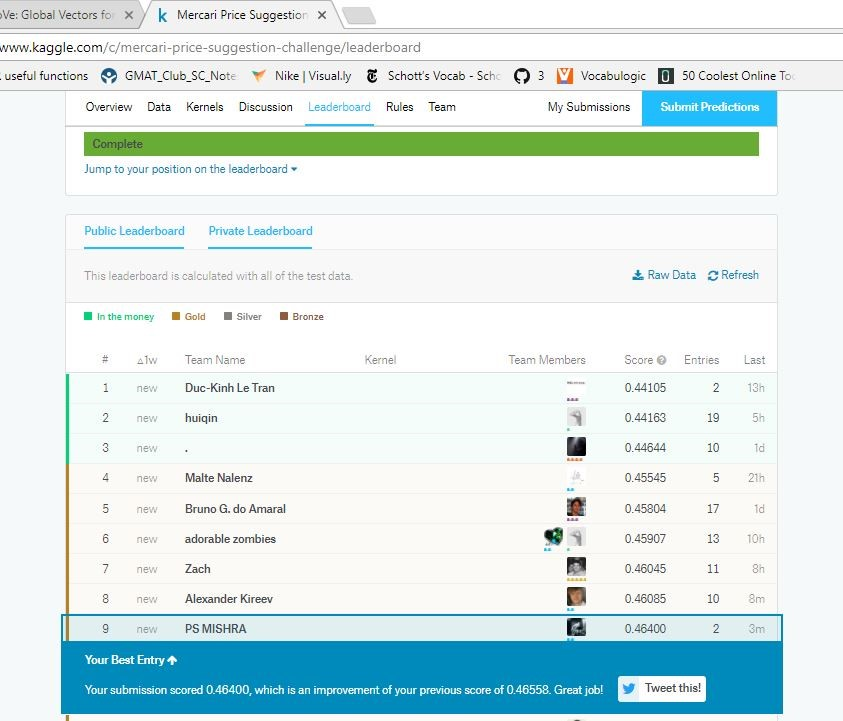

In [41]:
from IPython.display import Image
Image(filename='files/result.jpg')

## Context

### <u>1. Background of the problem</u> :
Product pricing gets harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs. Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

### <u>2. Objective for the competiton event</u>: 
In this competition, Mercari’s challenge is to build an algorithm that automatically suggests the right product prices. Assessment of the submissions is done as per the following rules - 

1. All submissions of the model have to be done <b> through the kernel only </b>. Unlike previous competitions, where users with extremely high computation power had an edge on similar porblems, Mercari has decided to limit usage and submission of all entries through its kernel on Google Cloud only

2. The leaderboard of the event is computed based on running the kernel in the process defined above and targeting the <b>lowest RMSLE</b>

3. Users can use external, <b>public data like Glove/word2vec</b> attached to the kernel. Using custom data (private) is not allowed in the current event

### <u>3. Data provided</u>: 
Users are provided user-inputted text descriptions of Mercari's products, including details like product category name, brand name, and item condition. Details of variables are as following - 

1.<b>train_id or test_id</b> - the id of the listing

2.<b>name</b> - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. dollars 20) to avoid leakage. These removed prices are represented as [rm]

3.<b>item_condition_id</b> - the condition of the items provided by the seller

4.<b>category_name</b> - category of the listing

5.<b>brand_name</b>

6.<b>price</b>- the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column 
doesn't exist in test.tsv since that is what you will predict.

7.<b>shipping</b> - 1 if shipping fee is paid by seller and 0 by buyer

8.<b>item_description</b> - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

## Rationale for choosing this problem

1. Mercari Price suggestion challenge is not limited to a large scale revenue impact problem alone, but also concerns organizations which have less structured descriptors of the product (color, size, product type, etc.)

2. Given the revenue projection of B2B industries and marketplaces, this problem becomes even more interesting and complex given the nuances of text descriptions, differing semantics for same products and varying prices across time, and less moderation with respect to what users post (sellers especially)

3. This domain is also an evolving domain with respect to the solution paradigm as it involves a blend of text mining, natural language processing, deep learning models and extremely crucial ETL with respect to feature engineering. Requirement of business domain is yet another aspect that makes this problem class very challenging.

## Solution Design

The solution pipeline has been broken down into 8 different steps:  
    1. ETL and normalization - All the necessary libraries and data are imported at this step along with standardization of feature names
    
    2. Feature engineering - Since the data is limited to 7 features and a standard text description, it becoems extremely crucial to choose a strong feature engineering approach that is not too heavy for the kernel operation but yields high accuracy at the same time. 
    
    3. Imputation and missing value treatment - This step takes care of missing values/ outliers and caps the limit of text sequences used for training and predictions
    
    4. Tokenization and text to sequence conversions</b> - Since the input features involve a large number of textual information, converting them into sequences and tokens for keras model is done at this stage. Exploratory data anlysis at this stage to pick up right max lengths for keras embedding is also performed
    
    5. Development, train, test designs - Spliting of dataset for development samples
    
    6. Keras data definitions - Defining all layers of data model for Keras engine
    
    7. Model training and fit - Running the defined keras model on 3.5m rows to generate model file
    
    8. Submissions - Predicting prices for test data and generating submission file

##                                              DETAILED SOLUTION

## Step 1 : File i/o and Library instantiation

Three files - (1) <u> train data </u> with product description, target variable (price), and other descriptors like category tree, brand name, item condition etc, <u> test data </u> on which the scores are computed post submission, along with <u> submission file format</u> were provided to all users. The scores are computed on the entire test data for phase 1 (700 k rows)

### (1.1) Import libraries and encodings

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

### (1.2) Define rmsle function which is the default scoring mechanism for this event

In [ ]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

### (1.3) Load train and test data

In [ ]:
#LOAD DATA
print("Loading data...")
train = pd.read_table("../input/train.tsv")
test = pd.read_table("../input/test.tsv")
print(train.shape)
print(test.shape)

In [ ]:
train.head()

## Step 2 : Feature engineering and Format Refactoring

Functions and auxiliary variables created for data model development

1) <b>Category detail parser</b> : The category information for the products consists of a '/' separated mulit-level entry. For example, 'men/shirts/homewear'. This function parses the information provided and provies the entries as different columns

2) <b>Price features aggregator</b> : This function aggregates mean, median, min and max of prices aggregated across the 3 category levels for each row

3) <b>Price features inserter</b> : Based on the aggregated price values created, this function creates new columns for each record in both train and test data

4) <b>Category features inserter</b> : This function inserts different category, brand and product features in the dataset. Details of these features are provided below - 
    a. Features to calculate the min, max, avg. of length of different category descriptors (catg level 1, level 2 & level 3)
    
    b. Features to calculate the min, max, avg. of length of different brand variables
    
    c. Features to calculate the min, max, avg. of length of different product descriptions
    
    d. Features to tag entries as outliers/ no outliers (depending upon their deviation)
    
    e. Features to input information about actual length of the text sequences (descriptions, associations etc.)

### (2.1) Define data types for variables

In [ ]:
train['item_condition_id'] = train['item_condition_id'].astype(np.int8)
train['shipping'] = train['shipping'].astype(np.int8)
test['item_condition_id'] = test['item_condition_id'].astype(np.int8)
test['shipping'] = test['shipping'].astype(np.int8)

In [ ]:
median_price = train['price'].median()
mean_price = train['price'].mean()
exclude_cols = ['name', 'category_name', 'brand_name', 'item_description', 'category_1', 'category_2', 'category_3']

### (2.2) Feature generation and engineering

In [ ]:
def category_detail(x, i):
    try:
        x = x.split('/')[i]
        return x
    except:
        return ''
def category_detail_1(x):
    return category_detail(x, 0)
def category_detail_2(x):
    return category_detail(x, 1)
def category_detail_3(x):
    return category_detail(x, 2)

def price_features_groupby(train, col, type):
    if(type == 'median'):
        price_dict = train.groupby(col)['price'].median().to_dict()
    elif(type == 'mean'):
        price_dict = train.groupby(col)['price'].mean().to_dict()
    elif(type == 'max'):
        price_dict = train.groupby(col)['price'].max().to_dict()
    else:
        price_dict = train.groupby(col)['price'].min().to_dict()
    tmp = pd.DataFrame({
        col:list(price_dict.keys()),
        '{}_{}_price'.format(col, type):list(price_dict.values())})
    return tmp
def price_features(train, test, col, type):
    na_value = -1
    if(type == 'median'):
        na_value = median_price
    elif(type == 'mean'):
        na_value = mean_price
        
    tmp = price_features_groupby(train, col, type)
    train = pd.merge(train, tmp, how='left', on=col)
    train['{}_{}_price'.format(col, type)].fillna(na_value, inplace=True)
    train['{}_{}_price'.format(col, type)] = train['{}_{}_price'.format(col, type)].astype(np.int16)
    
    test = pd.merge(test, tmp, how='left', on=col)
    test['{}_{}_price'.format(col, type)].fillna(na_value, inplace=True)
    test['{}_{}_price'.format(col, type)] = test['{}_{}_price'.format(col, type)].astype(np.int16)
    
    return train, test
    

def category_features(train, test, col):
    cate_train = set(train[col].unique())
    cate_test = set(test[col].unique())
    cate_all = cate_train.union(cate_test)
    print('category {} in train have {} unique values'.format(col, len(cate_train)))
    print('category {} in test have {} unique values'.format(col, len(cate_test)))
    print('category {} in train ∪ test have {} unique values'.format(col, len(cate_all)))
    print()
    tmp = pd.DataFrame({
        col:list(cate_all),
        '{}_cat'.format(col):[i+1 for i in range(len(cate_all))]})
    train = pd.merge(train, tmp, how='left', on=col) 
    train['{}_cat'.format(col)].fillna(-1, inplace=True) 
    test = pd.merge(test, tmp, how='left', on=col)
    test['{}_cat'.format(col)].fillna(-1, inplace=True)
    return train, test
train['category_1'] = train['category_name'].apply(category_detail_1)
train['category_2'] = train['category_name'].apply(category_detail_2)
train['category_3'] = train['category_name'].apply(category_detail_3)

test['category_1'] = test['category_name'].apply(category_detail_1)
test['category_2'] = test['category_name'].apply(category_detail_2)
test['category_3'] = test['category_name'].apply(category_detail_3)

for col in ['category_name','brand_name','category_1','category_2','category_3']:
    train, test = category_features(train, test, col)

for col in ['category_name','brand_name','category_1','category_2','category_3','item_condition_id']:
    for type in ['median','mean','max','min']:
        train, test = price_features(train, test, col, type)

# start https://www.kaggle.com/golubev/naive-xgboost-v2
c_texts = ['name', 'item_description']
def count_words(key):
    return len(str(key).split())
def count_numbers(key):
    return sum(c.isalpha() for c in str(key))
def count_upper(key):
    return sum(c.isupper() for c in str(key))
for c in c_texts:
    train[c + '_c_words'] = train[c].apply(count_words)
    train[c + '_c_upper'] = train[c].apply(count_upper)
    train[c + '_c_numbers'] = train[c].apply(count_numbers)
    train[c + '_len'] = train[c].str.len()
    train[c + '_mean_len_words'] = train[c + '_len'] / train[c + '_c_words']
    train[c + '_mean_upper'] = train[c + '_len'] / train[c + '_c_upper']
    train[c + '_mean_numbers'] = train[c + '_len'] / train[c + '_c_numbers']

for c in c_texts:
    test[c + '_c_words'] = test[c].apply(count_words)
    test[c + '_c_upper'] = test[c].apply(count_upper)
    test[c + '_c_numbers'] = test[c].apply(count_numbers)
    test[c + '_len'] = test[c].str.len()
    test[c + '_mean_len_words'] = test[c + '_len'] / test[c + '_c_words']
    test[c + '_mean_upper'] = test[c + '_len'] / test[c + '_c_upper']
    test[c + '_mean_numbers'] = test[c + '_len'] / test[c + '_c_numbers']
train['fe001'] = np.square(train["name_mean_len_words"])
train['fe002'] = np.square(train["item_description_mean_len_words"])
train['fe003'] = np.tanh(train["name_mean_len_words"])
train['fe004'] = np.tanh(train["item_description_mean_len_words"])
train['fe005'] = train["name_mean_len_words"]**2.37
#train['fe006'] = train[""]**2.15

test['fe001'] = np.square(test["name_mean_len_words"])
test['fe002'] = np.square(test["item_description_mean_len_words"])
test['fe003'] = np.tanh(test["name_mean_len_words"])
test['fe004'] = np.tanh(test["item_description_mean_len_words"])
test['fe005'] = test["name_mean_len_words"]**2.37
test['fe006'] = test["item_description_mean_len_words"]**2.15    
    
# end https://www.kaggle.com/golubev/naive-xgboost-v2



print('After adding features\nShape train: {}\nShape test: {}'.format(train.shape,test.shape))


## Step 3 : Imputation and Outlier/Missing Value treatment

Missing values are handled before generating tokens and sequences for long text entries. Similarly one hot encodings for words are created for feature engineering. These features will not be used in the first pass of embeddings but might be useful later

### (3.1) Missing value treatment for raw entries

In [ ]:
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

### (3.2) Processing categorical data for transformations and assigning to tokenizer input format

In [ ]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)


## Step 4 : Tokenization and text-to-sequence variables

For encoding all text entries into standard numeric sequences for keras data model, a tokenizer is called for item descriptions, and sequences of other categorical information based on text. It is worthwhile noting here that since the competition allows external public data import, in the next phase we can also use Glove/Word2vec embeddings for building better surface patterns

### (4.1) Raw text processing for tokenization and transorming text to sequence

In [ ]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Since the embedding layer in keras needs embedding layers, the next series of steps help extract the max unique labels for each feature at embedding layer. Based on the histogram (distribution) of item description, category and name, max lengths for instantiation are chosen

### (4.2) Analyzing output variables to assign lengths for embedding layers

In [ ]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

### (4.3) Checking histogram of sequence nnames and item descriptions

In [ ]:
train.seq_name.apply(lambda x: len(x)).hist()

In [ ]:
train.seq_item_description.apply(lambda x: len(x)).hist()

### (4.4) Choosing max values of embedding layer

In [ ]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

## Step 5 :  Target Variable Assignment and Development/test data generation

### (5.1) Taking log(price) as target variable and scaling 

In [ ]:
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

### (5.2)Creating development and test samples for model fit and validation

In [ ]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)
train.head(2)

## Step 6 : Data model definitions for Keras

A standard 4 layer net is developed with 112 inputs (based on the product text description, their length characteristics, associations like media/mean/min/max with prices across different aggregations, product features like item condition and shipping status etc. The net is fully connected and the embeddings are flattened before concatentation.)

### (6.1) Defining data model for keras input

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'cat_name_median_p':np.array(dataset.category_name_median_price)
        ,'cat_name_mean_p':np.array(dataset.category_name_mean_price)
        ,'cat_name_max_p':np.array(dataset.category_name_max_price)
       # ,'cat_name_min_p':np.array(dataset.category_name_min_price)
        ,'brand_name_median_p':np.array(dataset.brand_name_median_price)
        ,'brand_name_mean_p':np.array(dataset.brand_name_mean_price)
        #,'brand_name_max_p':np.array(dataset.brand_name_max_price)
        #,'brand_name_min_p':np.array(dataset.brand_name_min_price)
        ,'cat_1_median_p':np.array(dataset.category_1_median_price)
        ,'cat_1_mean_p':np.array(dataset.category_1_mean_price)
        #,'cat_1_max_p': np.array(dataset.category_1_max_price)
        #,'cat_1_min_p':np.array(dataset.category_1_min_price)
        ,'cat_2_median_p':np.array(dataset.category_2_median_price)
        ,'cat_2_mean_p':np.array(dataset.category_2_mean_price)
        #,'cat_2_max_p':np.array(dataset.category_2_max_price)
        #,'cat_2_min_p':np.array(dataset.category_2_min_price)
        ,'category_3_median_price' : np.array(dataset.category_3_median_price)
        #,'category_3_max_price' : np.array(dataset.category_3_max_price)
        ,'item_condition_id_median_price' : np.array(dataset.item_condition_id_median_price)
        ,'item_condition_id_max_price' : np.array(dataset.item_condition_id_max_price)
        ,'name_c_words' : np.array(dataset.name_c_words)
        ,'name_mean_len_words' : np.array(dataset.name_mean_len_words)
        #,'item_description_c_words' : np.array(dataset.item_description_c_words)
        #,'item_description_c_numbers' : np.array(dataset.item_description_c_numbers)
        #,'item_description_mean_len_words' : np.array(dataset.item_description_mean_len_words)
        #,'item_description_mean_numbers' : np.array(dataset.item_description_mean_numbers)
        ,'fe005' : np.array(dataset.fe005)
        ,'category_3_mean_price' : np.array(dataset.category_3_mean_price)
        #,'category_3_min_price' : np.array(dataset.category_3_min_price)
        ,'item_condition_id_mean_price' : np.array(dataset.item_condition_id_mean_price)
        ,'item_condition_id_min_price' : np.array(dataset.item_condition_id_min_price)
        #,'name_c_upper' : np.array(dataset.name_c_upper)
        #,'name_mean_upper' : np.array(dataset.name_mean_upper)
        #,'item_description_c_upper' : np.array(dataset.item_description_c_upper)
        #,'item_description_len' : np.array(dataset.item_description_len)
        #,'item_description_mean_upper' : np.array(dataset.item_description_mean_upper)
        ,'fe001' : np.array(dataset.fe001)
        #,'fe006' : np.array(dataset.fe006)
        ,'fe003' : np.array(dataset.fe003)
        ,'seq_name' : np.array(dataset.seq_name)
        ,'name_len' : np.array(dataset.name_len)
        #,'fe004' : np.array(dataset.fe004)
        ,'name_c_numbers' : np.array(dataset.name_c_numbers)
        #,'name_mean_numbers' : np.array(dataset.name_mean_numbers)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)
print("all datasets loaded")

### (6.2) Building all layers of keras model. 
To optimmize the runtime of the kernel, processes like batch normalization, regularization of droputs, fully connected layers at the point of embedding, and complicated architectures like RNN, LSTM etc. are not being used. The designated kernel designated for usage has a cut-off time of 60 minutes and the model has features in use keeping that in mind

In [ ]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    #num_vars = Input(shape[1]], name="num_vars")
    cat_name_median_p= Input(shape=[1], name = "cat_name_median_p")
    cat_name_mean_p= Input(shape=[1], name = "cat_name_mean_p")
    #cat_name_max_p= Input(shape=[1], name = "cat_name_max_p")
    #cat_name_min_p= Input(shape=[1], name = "cat_name_min_p")
    brand_name_median_p= Input(shape=[1], name = "brand_name_median_p")
    brand_name_mean_p= Input(shape=[1], name = "brand_name_mean_p")
    #brand_name_max_p= Input(shape=[1], name = "brand_name_max_p")
    #brand_name_min_p= Input(shape=[1], name = "brand_name_min_p")
    cat_1_median_p= Input(shape=[1], name = "cat_1_median_p")
    cat_1_mean_p= Input(shape=[1], name = "cat_1_mean_p")
    #cat_1_max_p= Input(shape=[1], name = "cat_1_max_p")
    #cat_1_min_p= Input(shape=[1], name = "cat_1_min_p")
    cat_2_median_p= Input(shape=[1], name = "cat_2_median_p")
    cat_2_mean_p= Input(shape=[1], name = "cat_2_mean_p")
    #cat_2_max_p= Input(shape=[1], name = "cat_2_max_p")
    #cat_2_min_p= Input(shape=[1], name = "cat_2_min_p")
    category_3_median_price= Input(shape=[1], name = "category_3_median_price")
    #category_3_max_price= Input(shape=[1], name = "category_3_max_price")
    item_condition_id_median_price= Input(shape=[1], name = "item_condition_id_median_price")
    item_condition_id_max_price= Input(shape=[1], name = "item_condition_id_max_price")
    name_c_words= Input(shape=[1], name = "name_c_words")
    #name_mean_len_words= Input(shape=[1], name = "name_mean_len_words")
    #item_description_c_words= Input(shape=[1], name = "item_description_c_words")
    #item_description_c_numbers= Input(shape=[1], name = "item_description_c_numbers")
    #item_description_mean_len_words= Input(shape=[1], name = "item_description_mean_len_words")
    #item_description_mean_numbers= Input(shape=[1], name = "item_description_mean_numbers")
    fe005= Input(shape=[1], name = "fe005")
    category_3_mean_price= Input(shape=[1], name = "category_3_mean_price")
    #category_3_min_price= Input(shape=[1], name = "category_3_min_price")
    item_condition_id_mean_price= Input(shape=[1], name = "item_condition_id_mean_price")
    item_condition_id_min_price= Input(shape=[1], name = "item_condition_id_min_price")
    name_c_upper= Input(shape=[1], name = "name_c_upper")
    #name_mean_upper= Input(shape=[1], name = "name_mean_upper")
    #item_description_c_upper= Input(shape=[1], name = "item_description_c_upper")
    #item_description_len= Input(shape=[1], name = "item_description_len")
    #item_description_mean_upper= Input(shape=[1], name = "item_description_mean_upper")
    fe001= Input(shape=[1], name = "fe001")
    #fe006= Input(shape=[1], name = "fe006")
    fe003= Input(shape=[1], name = "fe003")
    #seq_name= Input(shape=[1], name = "seq_name")
    name_len= Input(shape=[1], name = "name_len")
    #fe004= Input(shape=[1], name = "fe004")
    name_c_numbers= Input(shape=[1], name = "name_c_numbers")
    #name_mean_numbers= Input(shape=[1], name = "name_mean_numbers")
    #category_name= Input(shape=[1], name = "category_name")
    #item_condition= Input(shape=[1], name = "item_condition")
    num_vars= Input(shape=[1], name = "num_vars")
        
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_cat_name_median_p = Embedding(MAX_TEXT,5)(cat_name_median_p)
    emb_cat_name_mean_p = Embedding(MAX_TEXT,5)(cat_name_mean_p)
    #emb_cat_name_max_p = Embedding(MAX_TEXT,5)(cat_name_max_p)
    #emb_cat_name_min_p = Embedding(MAX_TEXT,5)(cat_name_min_p)
    emb_brand_name_median_p = Embedding(MAX_TEXT,5)(brand_name_median_p)
    emb_brand_name_mean_p = Embedding(MAX_TEXT,5)(brand_name_mean_p)
    #emb_brand_name_max_p = Embedding(MAX_TEXT,5)(brand_name_max_p)
    #emb_brand_name_min_p = Embedding(MAX_CATEGORY,5)(brand_name_min_p)
    emb_cat_1_median_p = Embedding(MAX_TEXT,5)(cat_1_median_p)
    emb_cat_1_mean_p = Embedding(MAX_TEXT,5)(cat_1_mean_p)
   # emb_cat_1_max_p = Embedding(MAX_TEXT,5)(cat_1_max_p)
   # emb_cat_1_min_p = Embedding(MAX_TEXT,5)(cat_1_min_p)
    emb_cat_2_median_p = Embedding(MAX_TEXT,5)(cat_2_median_p)
    emb_cat_2_mean_p = Embedding(MAX_TEXT,5)(cat_2_mean_p)
    #emb_cat_2_max_p = Embedding(MAX_TEXT,5)(cat_2_max_p)
    #emb_cat_2_min_p = Embedding(MAX_TEXT,5)(cat_2_min_p)
    emb_category_3_median_price = Embedding(MAX_TEXT,5)(category_3_median_price)
    #emb_category_3_max_price = Embedding(MAX_TEXT,5)(category_3_max_price)
    emb_item_condition_id_median_price = Embedding(MAX_TEXT,5)(item_condition_id_median_price)
    emb_item_condition_id_max_price = Embedding(MAX_TEXT,50)(item_condition_id_max_price)
    emb_name_c_words = Embedding(MAX_TEXT,50)(name_c_words)
    #emb_name_mean_len_words = Embedding(MAX_TEXT,50)(name_mean_len_words)
    #emb_item_description_c_words = Embedding(MAX_TEXT,50)(item_description_c_words)
    #emb_item_description_c_numbers = Embedding(MAX_TEXT,50)(item_description_c_numbers)
    #emb_item_description_mean_len_words = Embedding(MAX_TEXT,50)(item_description_mean_len_words)
    #emb_item_description_mean_numbers = Embedding(MAX_TEXT,50)(item_description_mean_numbers)
    emb_fe005 = Embedding(MAX_TEXT,5)(fe005)
    emb_category_3_mean_price = Embedding(MAX_TEXT,5)(category_3_mean_price)
    #emb_category_3_min_price = Embedding(MAX_TEXT,5)(category_3_min_price)
    emb_item_condition_id_mean_price = Embedding(MAX_TEXT,5)(item_condition_id_mean_price)
    emb_item_condition_id_min_price = Embedding(MAX_TEXT,5)(item_condition_id_min_price)
    #emb_name_c_upper = Embedding(MAX_TEXT,50)(name_c_upper)
    #emb_name_mean_upper = Embedding(MAX_TEXT,50)(name_mean_upper)
    #emb_item_description_c_upper = Embedding(MAX_TEXT,50)(item_description_c_upper)
    #emb_item_description_len = Embedding(MAX_TEXT,50)(item_description_len)
    #emb_item_description_mean_upper = Embedding(2147483650,50)(item_description_mean_upper)
    emb_fe001 = Embedding(10000,5)(fe001)
    #emb_fe006 = Embedding(10000,5)(fe006)
    emb_fe003 = Embedding(10000,5)(fe003)
    #emb_seq_name = Embedding(20,5)(seq_name)
    emb_name_len = Embedding(MAX_TEXT,50)(name_len)
    #emb_fe004 = Embedding(MAX_TEXT,5)(fe004)
    emb_name_c_numbers = Embedding(MAX_TEXT,5)(name_c_numbers)
    #emb_name_mean_numbers = Embedding(MAX_TEXT,5)(name_mean_numbers)
    #emb_category_name = Embedding(20,5)(category_name)
    emb_item_condition = Embedding(20,5)(item_condition)
    emb_num_vars = Embedding(20,5)(num_vars)

    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars, Flatten() (emb_cat_name_median_p)
, Flatten() (emb_cat_name_mean_p)
#, Flatten() (emb_cat_name_max_p)
#, Flatten() (emb_cat_name_min_p)
, Flatten() (emb_brand_name_median_p)
, Flatten() (emb_brand_name_mean_p)
#, Flatten() (emb_brand_name_max_p)
#, Flatten() (emb_brand_name_min_p)
, Flatten() (emb_cat_1_median_p)
, Flatten() (emb_cat_1_mean_p)
#, Flatten() (emb_cat_1_max_p)
#, Flatten() (emb_cat_1_min_p)
, Flatten() (emb_cat_2_median_p)
, Flatten() (emb_cat_2_mean_p)
#, Flatten() (emb_cat_2_max_p)
#, Flatten() (emb_cat_2_min_p)
, Flatten() (emb_category_3_median_price)
#, Flatten() (emb_category_3_max_price)
, Flatten() (emb_item_condition_id_median_price)
, Flatten() (emb_item_condition_id_max_price)
, Flatten() (emb_name_c_words)
#, Flatten() (emb_name_mean_len_words)
#, Flatten() (emb_item_description_c_words)
#, Flatten() (emb_item_description_c_numbers)
#, Flatten() (emb_item_description_mean_len_words)
#, Flatten() (emb_item_description_mean_numbers)
, Flatten() (emb_fe005)
, Flatten() (emb_category_3_mean_price)
#, Flatten() (emb_category_3_min_price)
, Flatten() (emb_item_condition_id_mean_price)
, Flatten() (emb_item_condition_id_min_price)
#, Flatten() (emb_name_c_upper)
#, Flatten() (emb_name_mean_upper)
#, Flatten() (emb_item_description_c_upper)
#, Flatten() (emb_item_description_len)
#, Flatten() (emb_item_description_mean_upper)
, Flatten() (emb_fe001)
#, Flatten() (emb_fe006)
, Flatten() (emb_fe003)
#, Flatten() (emb_seq_name)
, Flatten() (emb_name_len)
#, Flatten() (emb_fe004)
, Flatten() (emb_name_c_numbers)
#, Flatten() (emb_name_mean_numbers)
#, Flatten() (emb_category_name)
#, Flatten() (emb_item_condition)
#, Flatten() (emb_num_vars)

    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars, cat_name_median_p
, cat_name_mean_p
#, cat_name_max_p
#, cat_name_min_p
, brand_name_median_p
, brand_name_mean_p
#, brand_name_max_p
#, brand_name_min_p
, cat_1_median_p
, cat_1_mean_p
#, cat_1_max_p
#, cat_1_min_p
, cat_2_median_p
, cat_2_mean_p
#, cat_2_max_p
#, cat_2_min_p
, category_3_median_price
#, category_3_max_price
, item_condition_id_median_price
, item_condition_id_max_price
, name_c_words
#, name_mean_len_words
#, item_description_c_words
#, item_description_c_numbers
#, item_description_mean_len_words
#, item_description_mean_numbers
, fe005
, category_3_mean_price
#, category_3_min_price
, item_condition_id_mean_price
, item_condition_id_min_price
#, name_c_upper
#, name_mean_upper
#, item_description_c_upper
#, item_description_len
#, item_description_mean_upper
, fe001
#, fe006
, fe003
#, seq_name
, name_len
#, fe004
, name_c_numbers
#, name_mean_numbers
                  ], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()
    


### (6.3) Fitting the final keras model on the data

In [ ]:
#FITTING THE MODEL
BATCH_SIZE = 5000
epochs = 4

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

## Step 7 : Model evaluation and generating predictions on entire test data (~700k rows)

### (7.1) Evaluating the model on deveopment test sample post scaling

In [ ]:
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

### (7.2) Computing error metrics for testing

In [ ]:
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

### (7.3) Creating predictions on complete test data

In [ ]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

## Step 8 : Generating final submissions for the model

In [ ]:
submission.to_csv("./submission_for_mercari_psm.csv", index=False)